In [1]:
!pip install torch
!pip install transformers

import torch
from torch.utils.data import DataLoader, random_split
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertForSequenceClassification, T5Tokenizer, T5ForConditionalGeneration, RobertaTokenizer, RobertaForSequenceClassification, RobertaConfig

import gc
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from transformers.modeling_outputs import Seq2SeqLMOutput


from sklearn.metrics import accuracy_score

import torch.nn as nn
from transformers import RobertaForSequenceClassification, RobertaConfig

import pandas as pd
import random
from torch.utils.data import Dataset


## Thomas -- below for visualization
import time
import matplotlib.pyplot as plt
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 25.8 MB/s eta 0:00:00


In [2]:
class TweetDisasterDataset(Dataset):
    def __init__(self, csv_file: str):
        self.annotation = pd.read_csv(csv_file)
        

    def __len__(self):
        return len(self.annotation)

    def __getitem__(self, idx):
        row = self.annotation.iloc[idx]
        keyword = row['keyword']
        location = row['location']
        text = row['text']
        label = row['target']
        
        input_text = f"{keyword if pd.notnull(keyword) else ''} {location if pd.notnull(location) else ''} {text}"
       
        return {
            "text_input": input_text,
            "label": label,
        }
    

In [3]:
class SoftPromptTuning(nn.Module):
    def __init__(self, model: RobertaForSequenceClassification, prompt_length: int):
        super(SoftPromptTuning, self).__init__()
        self.model = model
        self.prompt_length = prompt_length
        self.soft_prompt_embeddings = nn.Parameter(torch.randn(prompt_length, self.model.config.hidden_size))

        # Freeze the Roberta model parameters
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, input_ids, attention_mask=None, labels=None):
        # Prepend the soft prompt embeddings to the input embeddings
        input_embeddings = self.model.roberta.get_input_embeddings()(input_ids)
        prompt_embeddings = self.soft_prompt_embeddings.unsqueeze(0).repeat(input_embeddings.size(0), 1, 1)
        combined_embeddings = torch.cat((prompt_embeddings, input_embeddings), dim=1)

        # Adjust the attention mask if provided
        if attention_mask is not None:
            attention_mask = torch.cat((torch.ones(input_embeddings.size(0), self.prompt_length).to(attention_mask.device), attention_mask), dim=1)

        # Feed the combined embeddings through the model
        outputs = self.model(inputs_embeds=combined_embeddings, attention_mask=attention_mask, labels=labels)

        return outputs
    

In [14]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def validate_epoch(model, dataloader, tokenizer, max_len, device):
    model.eval()
    total_loss = 0.0
    total_accuracy = 0.0
    total_samples = 0
    
    with torch.no_grad():
        for batch in dataloader:
            text_input = batch["text_input"]
            label = batch["label"]
            
            # Tokenize the text_input
            encoding = tokenizer(text_input, add_special_tokens=True, truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
            
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)
            
            # Convert labels to tensor and move to device
            labels = label.clone().detach().to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            # Generate predictions
            predicted_tokens = outputs.logits.argmax(dim=-1)

            # Calculate the accuracy
            batch_size = len(labels)
            accuracy = (predicted_tokens == labels).sum().item() / batch_size
            total_accuracy += accuracy * batch_size
            total_samples += batch_size

    average_loss = total_loss / len(dataloader)
    average_accuracy = total_accuracy / total_samples
    
        
    gc.collect()
    torch.cuda.empty_cache()

    return average_loss, average_accuracy


def train_epoch(model, dataloader, optimizer, scheduler, tokenizer, max_len, device):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    total_samples = 0

    for batch in dataloader:


        text_input = batch["text_input"]
        label = batch["label"]
        
        # Tokenize the text_input
        encoding = tokenizer(text_input, add_special_tokens=True, truncation=True, padding='max_length', max_length=max_len, return_tensors='pt')
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        # Convert labels to tensor and move to device
        labels = label.clone().detach().to(device)
                
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Generate predictions
        predicted_tokens = outputs.logits.argmax(dim=-1)

        # Calculate the accuracy
        batch_size = len(labels)
        accuracy = (predicted_tokens == labels).sum().item() / batch_size
        total_accuracy += accuracy * batch_size
        total_samples += batch_size
        
    scheduler.step()
    average_loss = total_loss / len(dataloader)
    average_accuracy = total_accuracy / total_samples
        
    gc.collect()
    torch.cuda.empty_cache()

    return average_loss, average_accuracy


## Thomas Wong
## update of data for visualization in this function
def train(soft_prompt_model, train_dataloader, val_dataloader, optimizer, scheduler, tokenizer, max_len, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    soft_prompt_model.to(device)

    global t_loss,v_loss,t_acc,v_acc,base_valid_loss
    t_loss = []
    v_loss = []
    t_acc = []
    v_acc = []
    timetaken=0
    best_valid_loss = 0.999

    for epoch in range(epochs):
        start_time = time.time()
        train_loss, train_accuracy = train_epoch(soft_prompt_model, train_dataloader, optimizer, scheduler, tokenizer, max_len, device)
        val_loss, val_accuracy = validate_epoch(soft_prompt_model, val_dataloader, tokenizer, max_len, device)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)  
        
        if val_loss < best_valid_loss:
          best_valid_loss = val_loss
          torch.save(soft_prompt_model.state_dict(), 'best_prompt.pt')
        
        print(f'Epoch {epoch + 1}/{epochs} -- LR: {scheduler.get_last_lr()[0]:.6f} -- Training Loss: {train_loss:.4f} -- Training Accuracy: {train_accuracy:.4f} -- Validation Loss: {val_loss:.4f} -- Validation Accuracy: {val_accuracy:.4f}')
    
        t_loss.append(train_loss)
        v_loss.append(val_loss)
        t_acc.append(train_accuracy)
        v_acc.append(val_accuracy)

        timetaken += epoch_mins*60 + epoch_secs
    
    gc.collect()
    torch.cuda.empty_cache()

    
    
    
def test_epoch(model, dataloader, tokenizer,device):
    model.eval()
    total_accuracy = 0.0
    total_samples = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)

            # Generate predictions
            predicted_tokens = outputs.logits.argmax(dim=-1)

            # Calculate the accuracy
            batch_size = len(labels)
            accuracy = (predicted_tokens == labels).sum().item() / batch_size
            total_accuracy += accuracy * batch_size
            total_samples += batch_size

    average_accuracy = total_accuracy / total_samples
    return average_accuracy

In [15]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Create the model instance
config = RobertaConfig.from_pretrained("roberta-large")#large")
config.num_labels = 2

# Load the pre-trained model and tokenizer
model = RobertaForSequenceClassification.from_pretrained("roberta-large", config=config)
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# Initialize the soft prompt model
apply_soft_prompt = True
train_path = "train.csv"
test_path = "test.csv"
batch_size = 32
lr = 1e-2
weight_decay=1e-4
epochs =2
max_len=64
prompt_length=20


if apply_soft_prompt:
    model = SoftPromptTuning(model, prompt_length)

train_val_dataset = TweetDisasterDataset(train_path)
num_train, num_val = round(0.9 * len(train_val_dataset)), round(0.1 * len(train_val_dataset))
train_dataset, val_dataset = random_split(train_val_dataset, [num_train, num_val])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=False)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=epochs)

train(model, train_loader, val_loader, optimizer, scheduler, tokenizer, max_len, epochs)


Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

Epoch 1/2 -- LR: 0.005000 -- Training Loss: 0.6929 -- Training Accuracy: 0.5517 -- Validation Loss: 0.6705 -- Validation Accuracy: 0.5926
Epoch 2/2 -- LR: 0.000000 -- Training Loss: 0.6859 -- Training Accuracy: 0.5663 -- Validation Loss: 0.6641 -- Validation Accuracy: 0.5926


# **Training outcome visualization**

<ipython-input-16-469b104f9ac9>:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


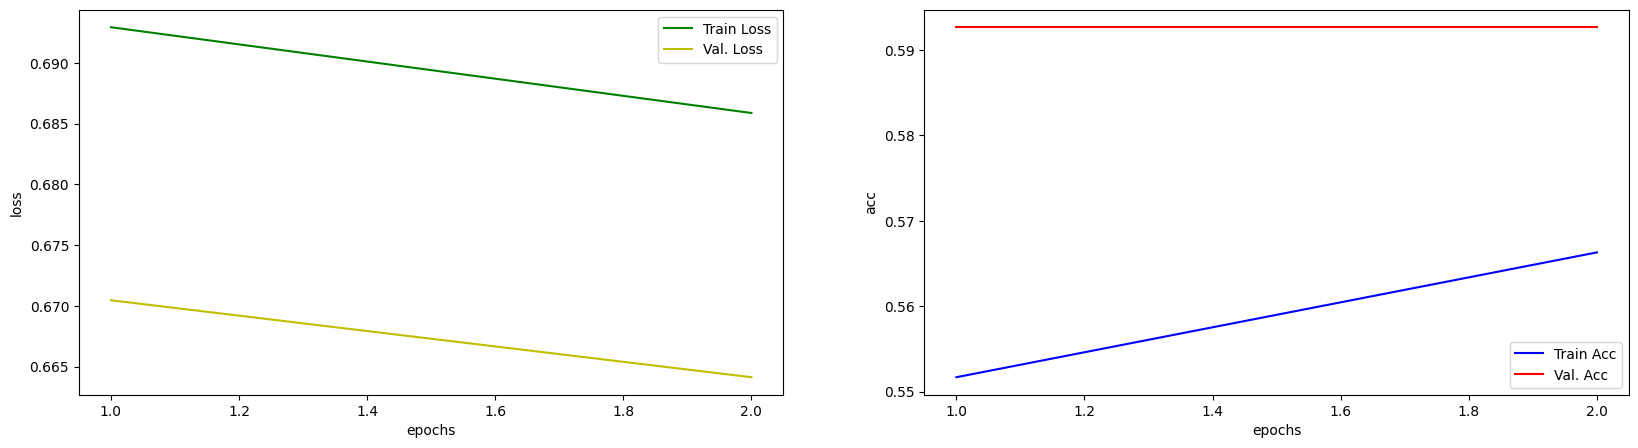

In [16]:
# display the result out graphically

eps = range(1, epochs+1)


plt.subplots(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(eps,t_loss,"g", label="Train Loss")
plt.plot(eps,v_loss,"y", label="Val. Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(eps,t_acc,"b", label="Train Acc")
plt.plot(eps,v_acc,"r", label="Val. Acc")
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend()

plt.show()

In [17]:
if False: #args.test:
    test_dataset = TweetDisasterDataset(test_path)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    test_accuracy = test_epoch(model, test_loader, tokenizer,device)
    print(f"Test accuracy: {test_accuracy:.4f}")